In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import groupGenMethods as groupGen

# Hello
## This is a method for clustering, generating and evaluating generated signals. Clustering is supported in one of three methods. The generation of signals happens through a GAN. The evaluation of proper generation is done via comparing L2 distances in the relevant clustering space. 

## The signals in question always undergo some transformation to generate a representative vector. With all the signals' vectors, the clustering occurs. This is because, based on year-long building load profiles at 15-minute intervals, the signals are too long to be clustered in their raw form.

## This notebook selects a cluster at random and the signal closest to its center. The GAN is trained to imitate that signal. Ideally, the generated signal's representative vector in the clustering space would be closest to the representative vectors of other signals in the same cluster.


## The three clustering methods are as follows:

1. Five parameter clustering inspired by Wang and Hong's "Generating realistic building electrical load profiles through the GAN" (https://www.sciencedirect.com/science/article/pii/S0378778820307234)

2. Frequency spectrum of the signal. A custom vector of length 15 representing the strength of 15 different frequencies in the signal. The frequencies aim to represent daily, weekly and annual patterns.

3. Low dimensional weekly average. With 15-minute resolution, each building has thousands of entries in its signal. The average weekday signal with $(4)(24)(5)$ entries is resampled to have 96 entries. 

## The data used here came from NREL labs (https://data.openei.org/submissions/4520)

In [2]:
goodData = groupGen.prep_data()
Nblds = len(goodData)
# no weekends, no bad buildings, matrix

In [3]:
normData, muData, sdData = groupGen.norm(np.float32(goodData),indx=1)
# normalized building data, s.t. each building signal has mean 0 sd 1

In [4]:
def fiveParamsClustering(normData):
    '''
    this function returns transforms the rows of 'normData' into
    vectors of length five according to the parameters generated by Wang & Hong. 
    Additionally, the parameters are normalized such that each resulting 
    column has mean 0 and standard deviation 1. 
    
    we also return the five means and standard deviations of the 
    five parameters of all signals in 'normData' so that future
    generated signals can be similarly scaled for cluster comparisons
    
    USE WITH 'fiveParamsClusteringGen()' function
    '''
    in_prms, in_prms_mu, in_prms_std = groupGen.params5(normData)
    nClustPrms = (in_prms - in_prms_mu)/in_prms_std
    return nClustPrms, in_prms_mu, in_prms_std

    
def lowDimClustering(normData):
    '''
    this method first finds the average weekdays in each row of 'normData'
    and then resamples those signals to have 96 rather than 480 entries.
    Note that, assuming the input signals are normalized, the generated
    resampled averages should also have mean 0 and standard deviation 1
    
    USE WITH 'lowDimClustering()' function
    '''
    weekNormData = normData.reshape(Nblds, -1,24*4*5)
    avgNormWeek = np.mean(weekNormData,1)
    nClustPrms = scipy.signal.resample(avgNormWeek, num = 96, axis=1)
    return nClustPrms

def freqSpectrumClustering(normData):
    vecLen = normData.shape[1]
    x=np.arange(0,2*np.pi,2*np.pi/vecLen).reshape(1,vecLen)
    ''' 
    we create a vector such that our entire signal is as long as one cycle of sin(x),
    we add other frequencies to represent weekly and daily patterns, for signals other
    than the sample signal, other frequencies could be useful, or the N lowest terms of a 
    fourier transform can be useful there are 13 weeks in the data, and 65 days, and 
    about .25 years the remaining frequencies analyzed are simply multiples of these
    predetermined frequencies
    
    USE WITH 'freqSpectrimClustering()' function
    '''
    X = np.concatenate([x*.25, x*.5, x, x*2, x*4, x*13, x*26, x*52, x*104, x*208, x*65, x*130, x*260, x*520, x*1040],0)
    sines = np.sin(X)
    freqs = normData@ sines.T
    nClustPrms, in_prms_mu, in_prms_std = groupGen.norm(freqs, indx=0)
    return nClustPrms, in_prms_mu, in_prms_std, sines

Choose a clustering method. You can read about them above.

In [5]:
nClustPrms, in_prms_mu, in_prms_std = fiveParamsClustering(normData)
#nClustPrms = lowDimClustering(normData)
#nClustPrms, in_prms_mu, in_prms_std, sines = freqSpectrumClustering(normData)

In [6]:
centers, labels, _ = groupGen.exploreKs(nClustPrms, low = 8, high=15, runs=2)

k: 8 dbi: 1.182
k: 9 dbi: 1.173
k: 10 dbi: 1.187
k: 11 dbi: 1.168
k: 12 dbi: 1.163
k: 13 dbi: 1.16
k: 14 dbi: 1.179
k: 15 dbi: 1.192

We'll go with 13 clusters


In [7]:
centerBlds = groupGen.clusterCenterBlds(centers, nClustPrms)

indeces on graphs refer to indeces in following array, not building indeces

 (array([  25,   30,  215,  269,  272,  292,  353,  373,  376,  377,  555,
        570,  594,  618,  669,  784,  820,  830,  879,  883, 1022, 1066],
      dtype=int64),)


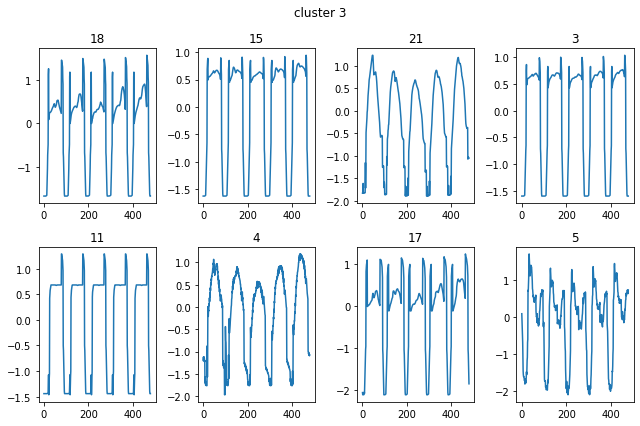

In [8]:
cluster = 3
#we'll use central building in cluster
bld = centerBlds[cluster]
print('indeces on graphs refer to indeces in following array, not building indeces\n\n',np.where(labels==cluster))
groupGen.dispRandRows(normData[np.where(labels==cluster)][:,:24*4*5],7, figsize=(9,6), title='cluster '+str(cluster))

we've picked building 272, which is closest to the center of cluster 3


array([ 7,  5,  9,  0, 12])

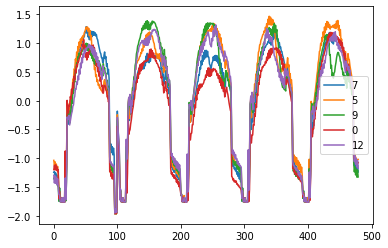

In [9]:
print(f"we've picked building {bld}, which is closest to the center of cluster {cluster}")
blddata = normData[bld]
groupGen.showRandRows(blddata.reshape(13,24*4*5),5,True)

In [10]:
wrongdays=groupGen.makeWrongDays(cluster=cluster,bldCenters= centerBlds,data=normData,labels=labels)
#this is a data set of all the central buildigns of other clusters.
#They will be used for training. Not only we want our generated buildings 
#to resemble the source clusters, we want it to not resemble other clusters.
print('we have counter examples ready in this',wrongdays.shape ,
      'matrix\n now let us prepare good exmaples for signal generation')

we have counter examples ready in this (73740, 96) matrix
 now let us prepare good exmaples for signal generation


our data for training has shape  (6145, 96, 1)


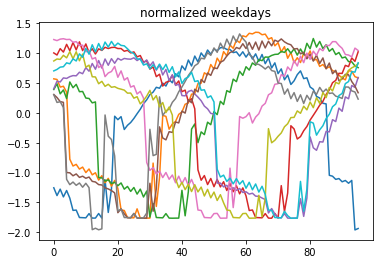

In [11]:
x,y = groupGen.splitSeqs(blddata.T,0,24*4)
yn_tensor = y.reshape(y.shape[0], y.shape[1],1)
groupGen.showRandRows(yn_tensor[:,:,0],10)
plt.title('normalized weekdays');
print("our data for training has shape ", yn_tensor.shape)

# don't worry about the imbalance in our thousands of training samples 
# and tens of thousands of counterexamples, the GAN code will grab balanced numbers
# out of both of them when training

In [12]:
latent_dim = 16
batch = 128
d_arch = 'c3 c3 c4 c4 f d28 d24 d12 d6'
g_arch = '12 16 24 32'
#our code makes a convolutional model based on the strings above
discriminator = groupGen.define_discriminator(n_inputs=24*4,
                                         arch = d_arch)
generator = groupGen.define_generator(latent_dim,
                                 n_outputs =24*4,
                                 in_shape=(batch,latent_dim,1), 
                                 arch= g_arch)
gan_model = groupGen.define_gan(generator, discriminator)

In [13]:
if not os.path.exists("records"): 
    # if the records folder isn't there, make one, otherwise future lines will fail
    os.makedirs("records")

## It's training time
It's a good idea to  put a descriptive, unique label into the train function below

EPOCH:  5   REAL ACC:  0.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


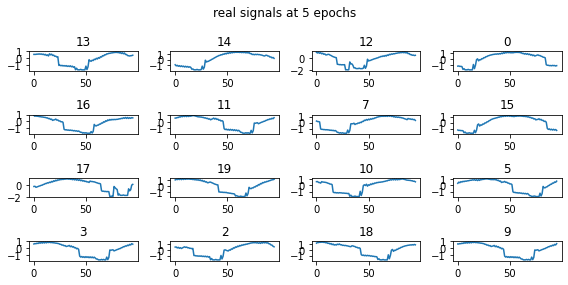

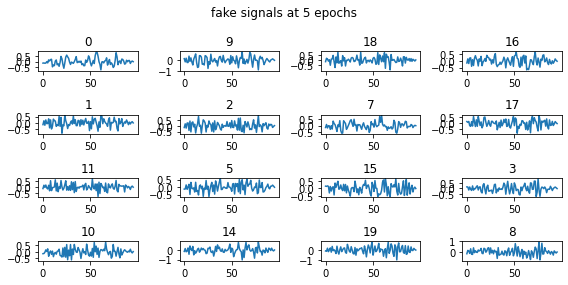

FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
 We're doing about 200 epochs in  2.82  min
EPOCH:  50   REAL ACC:  0.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


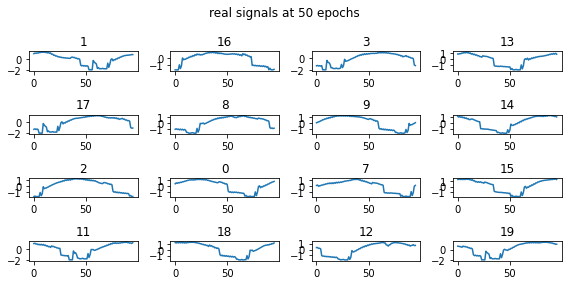

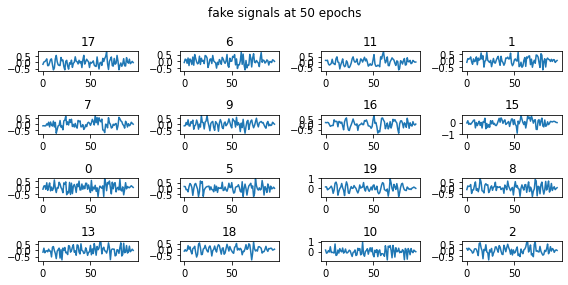

FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
 We're doing about 200 epochs in  0.93  min
EPOCH:  99   REAL ACC:  0.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


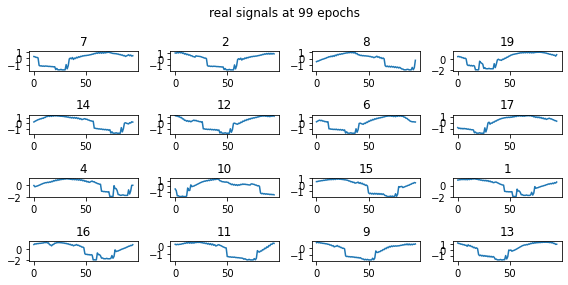

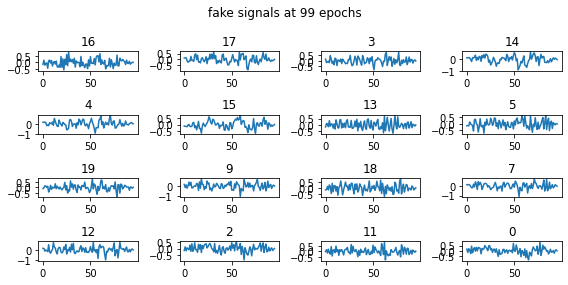

FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50
 We're doing about 200 epochs in  0.89  min


In [14]:
mylabel = 'FinalClean03'
groupGen.train(generator, discriminator, gan_model,
          latent_dim, M=yn_tensor, 
          n_epochs=100,n_eval=50, 
          label =mylabel+g_arch+'_'+d_arch+'_'+groupGen.tstr()[4:-8],
          wrong_signals = wrongdays)

Seeing the final generated, 'fake', signals is useful, but we'd rather have a quantitative metric of the generated signal's similarity to the desired cluster and to other clusters.

The training code saved a few generated curves with the relevant label, architectures used, and date and time. Let's find them and look at them.

In [15]:
curveFiles = [i for i in os.listdir('records/') if ('npy' in i and mylabel in i) ]
print(curveFiles)

['FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_19_46.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_34.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_38.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_41.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_44.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_48.npy', 'FinalClean0312 16 24 32_c3 c3 c4 c4 f d28 d24 d12 d6_Mar_24_20_50.npy']


## Let's compared the generated curves to those in their source cluster

In [16]:
curves = np.load('records/'+curveFiles[0]).reshape(1,-1)

In [17]:
normCurves, muCurves, sdCurves = groupGen.norm(np.float32(curves),indx=1)
# normalized generated building data, s.t. each generated signal has mean 0 sd 1

In [18]:
def fiveParamsClusteringGen(normCurves, in_prms_mu, in_prms_std):
    '''
    method to generate a similar vector representation to that made in
    the 'fiveParamsClustering()' function.
    
    Intended for use on generated signals so they may be compared 
    to a body of existing signals in a given clustering space.
    '''
    gen_prms, gen_prms_mu, gen_prms_st = groupGen.params5(normCurves)
    n_gen_prms = (gen_prms - in_prms_mu)/in_prms_std
    return n_gen_prms

def lowDimClusteringGen(normCurves):
    '''
    method to generate a similar vector representation to that made in
    the 'lowDimClustering()' function.
    
    Note that like in its sister function, there is no need to normalize.
    
    Intended for use on generated signals so they may be compared 
    to a body of existing signals in a given clustering space.
    '''
    weekNormData = normCurves.reshape(normCurves.shape[0], -1,24*4*5)
    avgNormWeek = np.mean(weekNormData,1)
    n_gen_prms = scipy.signal.resample(avgNormWeek, num = 96, axis=1)
    return n_gen_prms

def freqSpectrumClusteringGen(normCurves, in_prms_mu, in_prms_std, sines):
    '''
    method to generate a similar vector representation to that made in
    the 'freqSpectrumClustering()' function.
    
    Intended for use on generated signals so they may be compared 
    to a body of existing signals in a given clustering space.
    '''
    genVecLen = normCurves.shape[1]
    freqs = normCurves@ sines[:,:genVecLen].T
    n_gen_prms = (freqs - in_prms_mu)/in_prms_std
    return n_gen_prms

In [19]:
n_gen_prms = fiveParamsClusteringGen(normCurves, in_prms_mu, in_prms_std)
#n_gen_prms = lowDimClusteringGen(normCurves)
#n_gen_prms = freqSpectrumClusteringGen(normCurves, in_prms_mu, in_prms_std, sines)

we'd like to be close to cluster 3


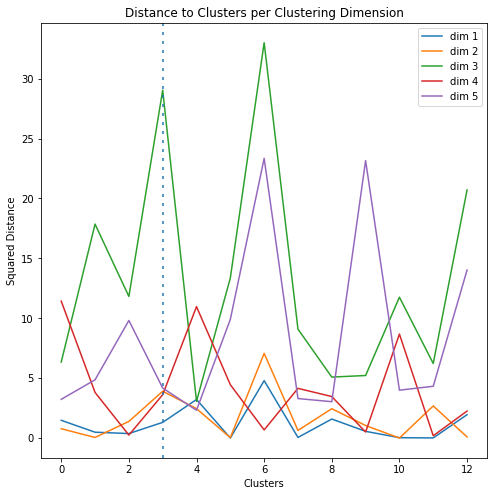

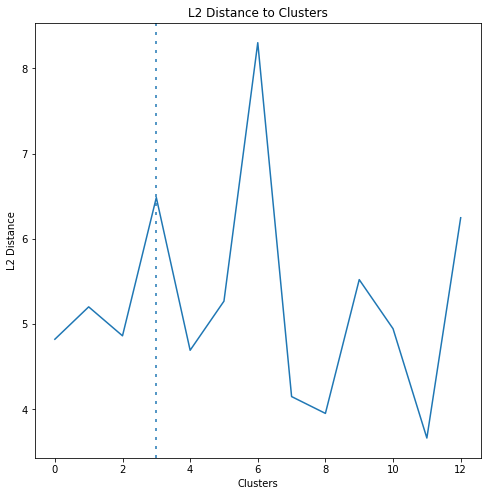

In [20]:
sqDist, L2 = groupGen.compParams(n_gen_prms, nClustPrms[centerBlds], cluster)